# Calculate Centrality Scores

In [6]:
import networkx as nx
import pickle
import pandas as pd

# Load the saved graph from file
with open("../data/processed/transaction_graph.gpickle", "rb") as f:
    G = pickle.load(f)

# Compute centrality metrics
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G)

# Create a DataFrame
centrality_df = pd.DataFrame({
    "node": list(G.nodes),
    "degree": [degree_centrality[n] for n in G.nodes],
    "betweenness": [betweenness_centrality[n] for n in G.nodes],
    "eigenvector": [eigenvector_centrality[n] for n in G.nodes],
})

# Identify Outliers via Centrality
### We’ll mark nodes with very high or very low centrality as anomalies

In [7]:
# Sort nodes by centrality
top_degree = centrality_df.sort_values("degree", ascending=False).head(10)
low_degree = centrality_df.sort_values("degree", ascending=True).head(10)

top_betweenness = centrality_df.sort_values("betweenness", ascending=False).head(10)
low_betweenness = centrality_df.sort_values("betweenness", ascending=True).head(10)

# Merge into one DataFrame of unique centrality-based anomalies
centrality_anomalies = pd.concat([
    top_degree, low_degree, top_betweenness, low_betweenness
]).drop_duplicates(subset="node")

# Identify Anomalies via Embedding Clustering

In [9]:
from node2vec import Node2Vec

# Rebuild Node2Vec model from graph G
node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=2)
model = node2vec.fit(window=10, min_count=1, batch_words=4)

# Get embeddings dictionary
embeddings = {str(node): model.wv[str(node)] for node in G.nodes()}

/Users/joy/Git/graph-taxpayer-network/graph-env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating walks (CPU: 2): 100%|██████████| 100/100 [00:01<00:00, 81.05it/s]


In [10]:
from sklearn.cluster import KMeans
import numpy as np

# Create matrix from embeddings
X = np.array(list(embeddings.values()))
nodes = list(embeddings.keys())

# Cluster into roles
kmeans = KMeans(n_clusters=5, random_state=42)
cluster_labels = kmeans.fit_predict(X)

# Calculate distances from each point to its cluster centroid
distances = np.linalg.norm(X - kmeans.cluster_centers_[cluster_labels], axis=1)

# Mark top-N furthest as role-based anomalies
n_anomalies = 20
outlier_indices = np.argsort(distances)[-n_anomalies:]
role_anomalies = [nodes[i] for i in outlier_indices]

role_anomalies_df = pd.DataFrame({"node": role_anomalies, "embedding_outlier_score": distances[outlier_indices]})

# Compare Overlap

In [11]:
# Compare with centrality anomalies
centrality_nodes = set(centrality_anomalies["node"])
role_nodes = set(role_anomalies_df["node"])

overlap = centrality_nodes.intersection(role_nodes)

print(f"🔁 Overlapping nodes: {len(overlap)}")
print(overlap)

🔁 Overlapping nodes: 10
{'C1481851679', 'C1975918135', 'C1695901686', 'C1112822222', 'C550754064', 'C50108055', 'C1141395669', 'C1938475526', 'C1553848604', 'C541258645'}


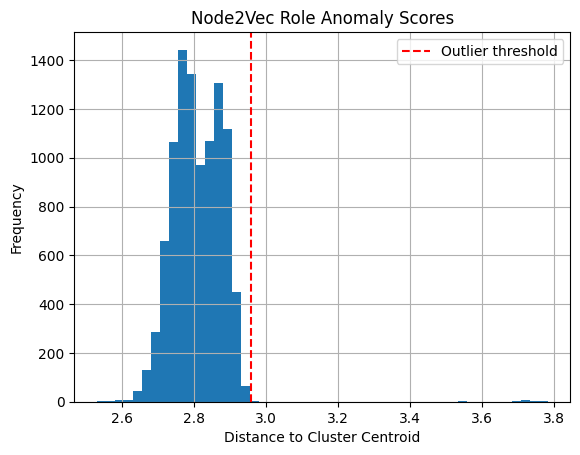

In [12]:
import matplotlib.pyplot as plt

# Visualize anomaly distance distribution
plt.hist(distances, bins=50)
plt.axvline(distances[outlier_indices[0]], color='r', linestyle='--', label='Outlier threshold')
plt.title("Node2Vec Role Anomaly Scores")
plt.xlabel("Distance to Cluster Centroid")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

# Mark and Merge Anomalies

In [15]:
# Mark centrality anomalies (top 20 by betweenness)
central_anomalies = centrality_df.nlargest(20, "betweenness")["node"].tolist()
centrality_df["is_central_anomaly"] = centrality_df["node"].isin(central_anomalies)

# Mark role anomalies
role_anomalies_df["is_role_anomaly"] = True

# Merge both
anomaly_comparison_df = centrality_df.merge(role_anomalies_df, on="node", how="outer")

# Fill missing with False
anomaly_comparison_df["is_central_anomaly"] = anomaly_comparison_df["is_central_anomaly"].fillna(False).astype(bool)
anomaly_comparison_df["is_role_anomaly"] = anomaly_comparison_df["is_role_anomaly"].fillna(False).astype(bool)

# Categorize
anomaly_comparison_df["anomaly_type"] = anomaly_comparison_df.apply(
    lambda row: 
    "Both" if row["is_central_anomaly"] and row["is_role_anomaly"] else
    "Centrality" if row["is_central_anomaly"] else
    "Role" if row["is_role_anomaly"] else
    "None",
    axis=1
)

/var/folders/ky/ll0bp0911cgbh1fk459zjgjr0000gn/T/ipykernel_65644/3929637360.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  anomaly_comparison_df["is_role_anomaly"] = anomaly_comparison_df["is_role_anomaly"].fillna(False).astype(bool)


# Visualize Overlap with Venn Diagram

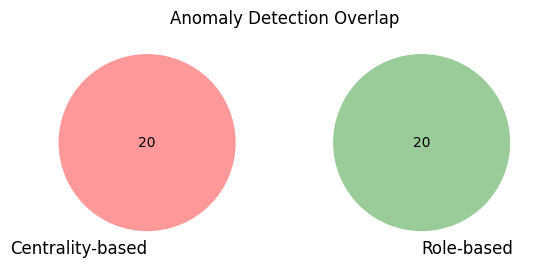

In [17]:
from matplotlib_venn import venn2
import matplotlib.pyplot as plt

venn2(
    subsets = (
        anomaly_comparison_df["is_central_anomaly"].sum(), 
        anomaly_comparison_df["is_role_anomaly"].sum(), 
        anomaly_comparison_df.query("is_central_anomaly & is_role_anomaly").shape[0]
    ),
    set_labels = ("Centrality-based", "Role-based"),
)
plt.title("Anomaly Detection Overlap")
plt.show()

# Embedding Visualization with Highlighted Anomalies

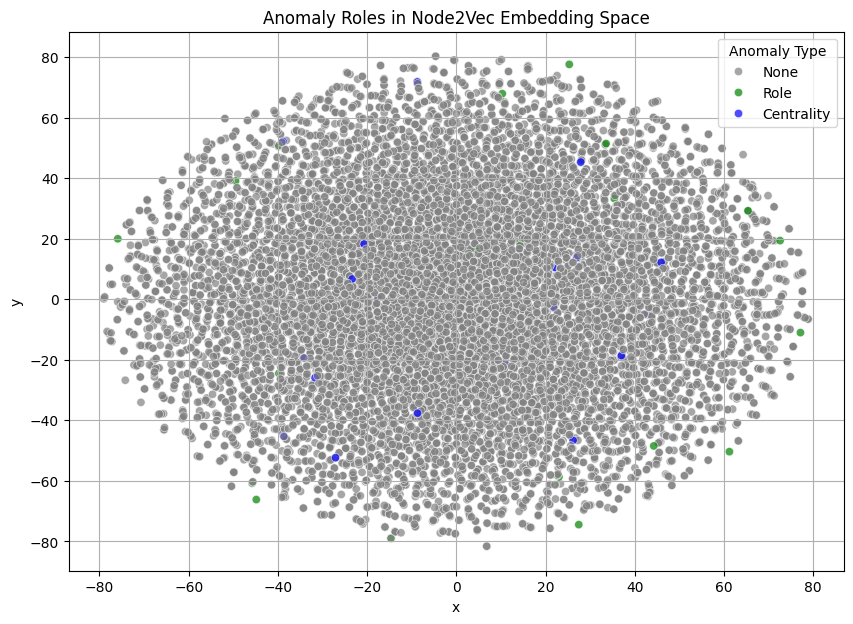

In [18]:
from sklearn.manifold import TSNE
import numpy as np

# Only keep nodes with embeddings
valid_df = anomaly_comparison_df[anomaly_comparison_df["node"].isin(embeddings)]

X = np.array([embeddings[n] for n in valid_df["node"]])
tsne = TSNE(n_components=2, random_state=42)
X_2d = tsne.fit_transform(X)

valid_df["x"] = X_2d[:, 0]
valid_df["y"] = X_2d[:, 1]

import seaborn as sns
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=valid_df,
    x="x", y="y",
    hue="anomaly_type",
    palette={"None": "gray", "Centrality": "blue", "Role": "green", "Both": "red"},
    alpha=0.7
)
plt.title("Anomaly Roles in Node2Vec Embedding Space")
plt.legend(title="Anomaly Type")
plt.grid(True)
plt.show()

# t-SNE Embedding Plot with Anomalies Highlighted

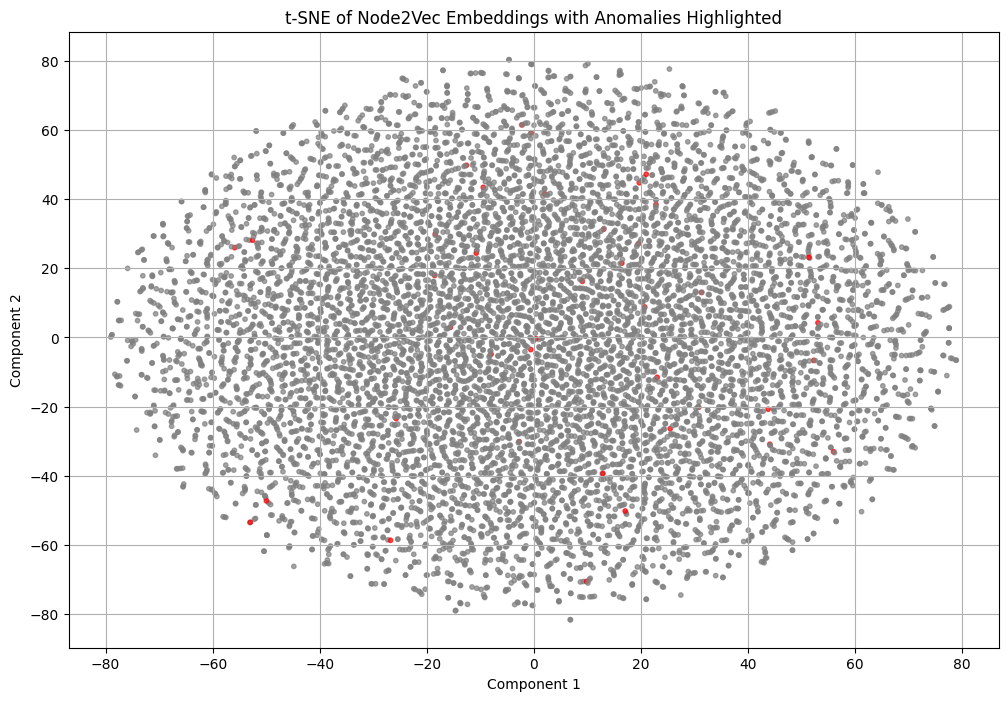

In [19]:
import matplotlib.pyplot as plt

# Assume X_2d and role_anomalies from earlier Node2Vec + t-SNE
# Also assume 'nodes' = list of node IDs in the same order as X_2d

# Prepare coloring
highlight_nodes = set(central_anomalies) | set(role_anomalies)
colors = ["red" if node in highlight_nodes else "gray" for node in nodes]

plt.figure(figsize=(12, 8))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=colors, s=10, alpha=0.7)
plt.title("t-SNE of Node2Vec Embeddings with Anomalies Highlighted")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.show()

# Bar Plot of Anomaly Types

/var/folders/ky/ll0bp0911cgbh1fk459zjgjr0000gn/T/ipykernel_65644/1254059014.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=anomaly_comparison_df[anomaly_comparison_df["anomaly_type"] != "None"],


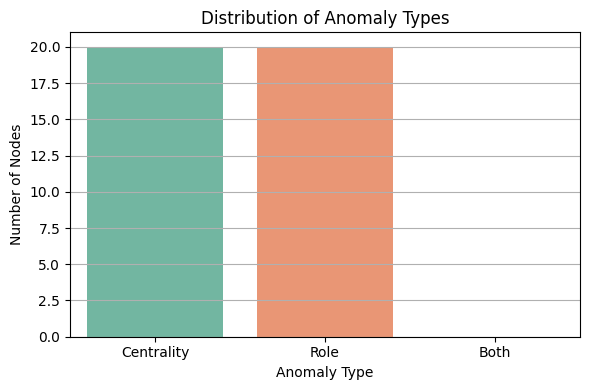

In [20]:
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.countplot(data=anomaly_comparison_df[anomaly_comparison_df["anomaly_type"] != "None"],
              x="anomaly_type", order=["Centrality", "Role", "Both"],
              palette="Set2")

plt.title("Distribution of Anomaly Types")
plt.ylabel("Number of Nodes")
plt.xlabel("Anomaly Type")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

In [21]:
anomaly_comparison_df.to_csv("../outputs/anomaly_summary.csv", index=False)